In [1]:
setwd('/import/DB/zhang//data')

In [2]:
getwd()

[1] "/import/DB/zhang/data"

In [3]:
library(Seurat)

Warning message:
"package 'Seurat' was built under R version 4.2.3"
The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, will retire in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.
The sp package is now running under evolution status 2
     (status 2 uses the sf package in place of rgdal)

Attaching SeuratObject



In [6]:
dir='.' 
samples = c('S1','S2','S3','S4')

In [7]:
sceList = lapply(samples,function(pro){ 
 #pro=samples[1]
 folder=file.path(dir ,pro ) 
 print(pro)
 print(folder)
 print(list.files(folder))
 sce=CreateSeuratObject(counts = Read10X(paste0(folder,'/filtered_feature_bc_matrix')),
 project = pro )

 return(sce)
})

[1] "S1"
[1] "./S1"
[1] "filtered_feature_bc_matrix"
[1] "S2"
[1] "./S2"
[1] "filtered_feature_bc_matrix"
[1] "S3"
[1] "./S3"
[1] "filtered_feature_bc_matrix"
[1] "S4"
[1] "./S4"
[1] "filtered_feature_bc_matrix"


In [8]:
single.ob=merge(sceList[[1]],sceList[2:length(sceList)])

Warning message in CheckDuplicateCellNames(object.list = objects):
"Some cell names are duplicated across objects provided. Renaming to enforce unique cell names."


In [9]:
single.ob

An object of class Seurat 
33538 features across 32723 samples within 1 assay 
Active assay: RNA (33538 features, 0 variable features)

In [10]:
immune.combined = single.ob

In [11]:
immune.combined[["percent.mt"]] <- PercentageFeatureSet(immune.combined,pattern = "^MT-")

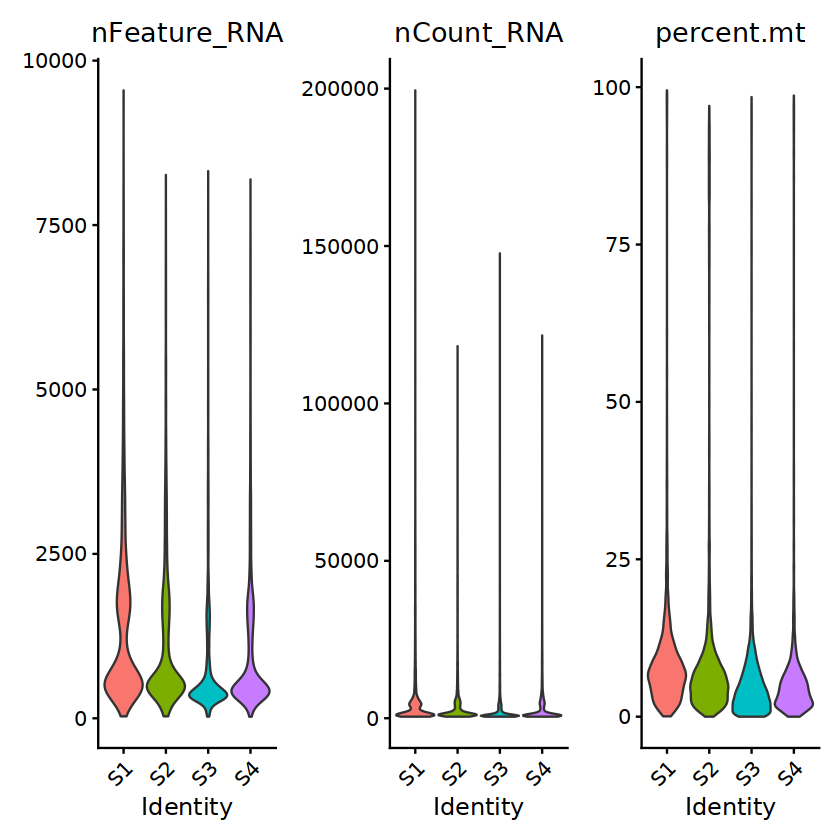

In [12]:
VlnPlot(immune.combined, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3,pt.size = 0,group.by="orig.ident")

In [13]:
library(ggplot2)

Warning message:
"package 'ggplot2' was built under R version 4.2.3"


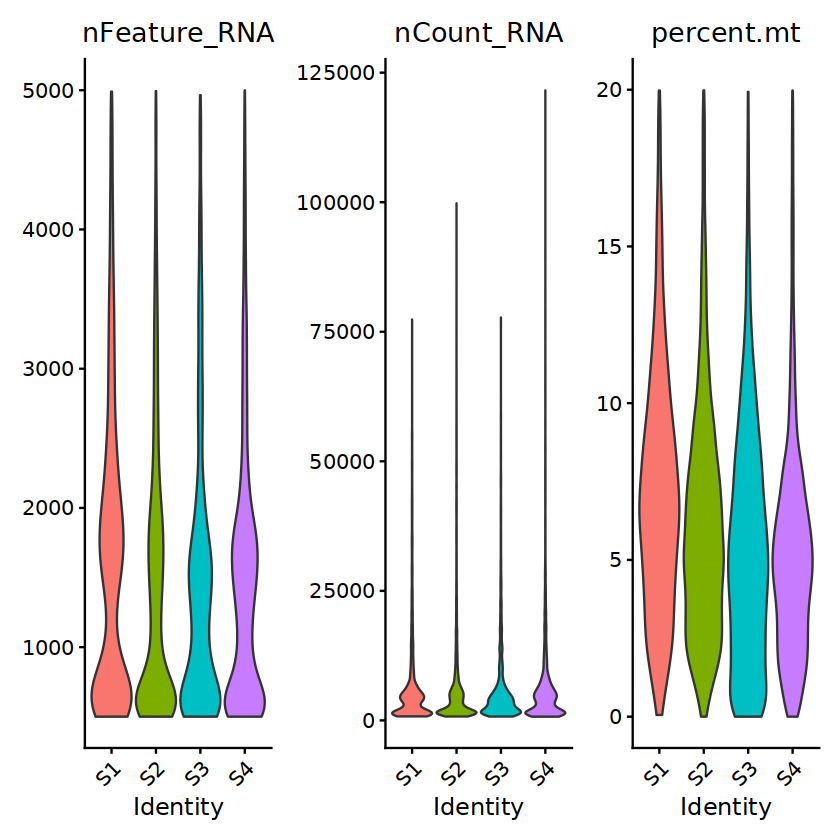

In [14]:
immune.combined <-   subset(immune.combined, subset = nFeature_RNA > 500 & nFeature_RNA < 5000 & percent.mt < 20)

VlnPlot(immune.combined, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3,pt.size = 0,group.by="orig.ident")


In [15]:
table(immune.combined$orig.ident)


  S1   S2   S3   S4 
3819 6720 2520 4878 

### 去除双细胞

In [16]:
library(DoubletFinder)
library(tidyverse)
library(Seurat)
library(patchwork)

Warning message:
"package 'tibble' was built under R version 4.2.3"
Warning message:
"package 'tidyr' was built under R version 4.2.3"
Warning message:
"package 'readr' was built under R version 4.2.3"
Warning message:
"package 'purrr' was built under R version 4.2.3"
Warning message:
"package 'dplyr' was built under R version 4.2.3"
Warning message:
"package 'stringr' was built under R version 4.2.3"
Warning message:
"package 'forcats' was built under R version 4.2.3"
Warning message:
"package 'lubridate' was built under R version 4.2.3"
Warning message in system("timedatectl", intern = TRUE):
"running command 'timedatectl' had status 1"
-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.2     v readr     2.1.4
v forcats   1.0.0     v stringr   1.5.0
v lubridate 1.9.2     v tibble    3.2.1
v purrr     1.0.1     v tidyr     1.3.0
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::

In [17]:
immune.combined <-NormalizeData(immune.combined)
immune.combined <- ScaleData(immune.combined,feature=rownames(immune.combined), verbose = FALSE)
immune.combined <- FindVariableFeatures(object = immune.combined,selection.method = 'vst', nfeatures = 2000)
immune.combined <- RunPCA(immune.combined,  features = VariableFeatures(object = immune.combined) ,verbose = FALSE)
immune.combined <- RunUMAP(immune.combined, reduction = "pca", dims = 1:20)
immune.combined <- RunTSNE(immune.combined, reduction = "pca", dims = 1:20)
immune.combined <- FindNeighbors(immune.combined, reduction = "pca", dims = 1:20)
immune.combined <- FindClusters(immune.combined)

Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"
07:50:20 UMAP embedding parameters a = 0.9922 b = 1.112

07:50:20 Read 17937 rows and found 20 numeric columns

07:50:20 Using Annoy for neighbor search, n_neighbors = 30

07:50:20 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

07:50:22 Writing NN index file to temp file /tmp/RtmpibhLQ0/file3478ab2d7172

07:50:22 Searching Annoy index using 1 thread, search_k = 3000

07:50:27 Annoy recall = 100%

07:50:27 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors 

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 17937
Number of edges: 669400

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9263
Number of communities: 27
Elapsed time: 5 seconds


In [18]:
H9 = immune.combined

In [19]:
paramSweep = function (seu, PCs = 1:20, sct = FALSE, num.cores = 1) 
{
    require(Seurat)
    require(fields)
    require(parallel)
    pK <- c(5e-04, 0.001, 0.005, seq(0.01, 0.3, by = 0.01))
    pN <- seq(0.05, 0.3, by = 0.05)
    min.cells <- round(nrow(seu@meta.data)/(1 - 0.05) - nrow(seu@meta.data))
    pK.test <- round(pK * min.cells)
    pK <- pK[which(pK.test >= 1)]
    orig.commands <- seu@commands
    if (nrow(seu@meta.data) > 10000) {
        real.cells <- rownames(seu@meta.data)[sample(1:nrow(seu@meta.data), 
            10000, replace = FALSE)]
        data <- seu@assays$RNA@counts[, real.cells]
        n.real.cells <- ncol(data)
    }
    if (nrow(seu@meta.data) <= 10000) {
        real.cells <- rownames(seu@meta.data)
        data <- seu@assays$RNA@counts
        n.real.cells <- ncol(data)
    }
    if (num.cores > 1) {
        require(parallel)
        cl <- makeCluster(num.cores)
        output2 <- mclapply(as.list(1:length(pN)), FUN = parallel_paramSweep, 
            n.real.cells, real.cells, pK, pN, data, orig.commands, 
            PCs, sct, mc.cores = num.cores)
        stopCluster(cl)
    }
    else {
        output2 <- lapply(as.list(1:length(pN)), FUN = parallel_paramSweep, 
            n.real.cells, real.cells, pK, pN, data, orig.commands, 
            PCs, sct)
    }
    sweep.res.list <- list()
    list.ind <- 0
    for (i in 1:length(output2)) {
        for (j in 1:length(output2[[i]])) {
            list.ind <- list.ind + 1
            sweep.res.list[[list.ind]] <- output2[[i]][[j]]
        }
    }
    name.vec <- NULL
    for (j in 1:length(pN)) {
        name.vec <- c(name.vec, paste("pN", pN[j], "pK", pK, 
            sep = "_"))
    }
    names(sweep.res.list) <- name.vec
    return(sweep.res.list)
}

In [20]:
sweep.res.list_kidney <- paramSweep(H9, PCs = 1:20, sct = FALSE)

Loading required package: fields

Loading required package: spam

Spam version 2.10-0 (2023-10-23) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.


Attaching package: 'spam'


The following objects are masked from 'package:base':

    backsolve, forwardsolve


Loading required package: viridisLite

Warning message:
"package 'viridisLite' was built under R version 4.2.3"

Try help(fields) to get started.

Loading required package: parallel



[1] "Creating artificial doublets for pN = 5%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.001..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 10%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.001..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 15%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.001..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 20%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.001..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 25%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.001..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 30%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.001..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."


Loading required package: KernSmooth

Warning message:
"package 'KernSmooth' was built under R version 4.2.3"
KernSmooth 2.23 loaded
Copyright M. P. Wand 1997-2009

Loading required package: ROCR

Warning message:
"package 'ROCR' was built under R version 4.2.3"


NULL


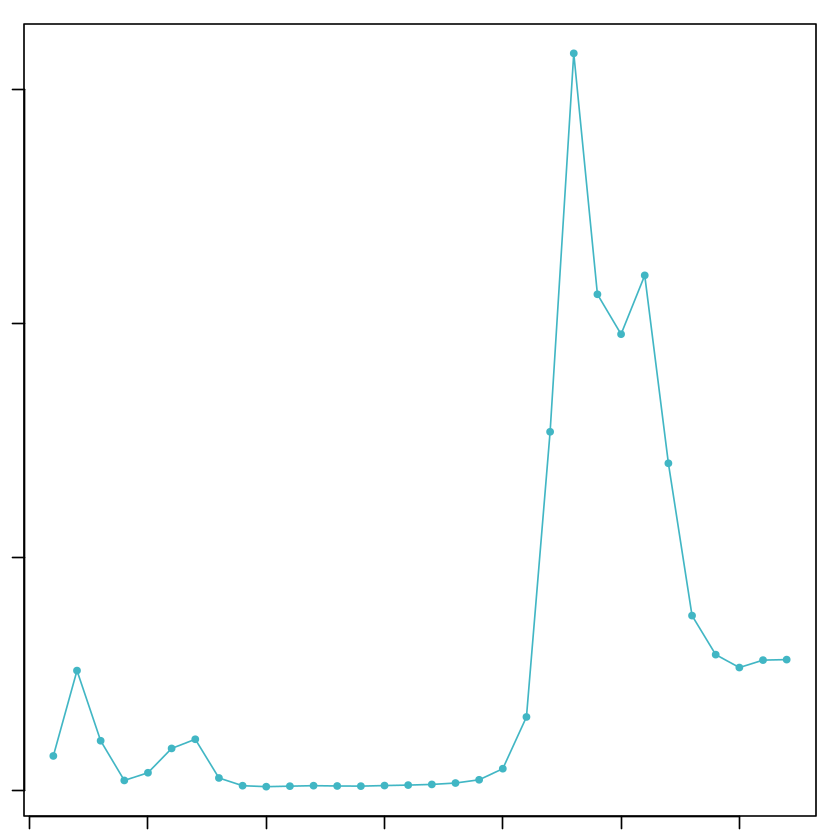

In [21]:
sweep.stats_kidney <- summarizeSweep(sweep.res.list_kidney, GT = FALSE)
bcmvn_kidney <- find.pK(sweep.stats_kidney)

In [22]:
pK_bcmvn <- bcmvn_kidney$pK[which.max(bcmvn_kidney$BCmetric)] %>% as.character() %>% as.numeric()

In [23]:
DoubletRate = ncol(H9)*8*1e-7

In [24]:
DoubletRate

[1] 0.0143496

In [25]:
homotypic.prop <- modelHomotypic(H9$orig.ident)

In [26]:
nExp_poi <- round(DoubletRate*ncol(H9)) 
nExp_poi.adj <- round(nExp_poi*(1-homotypic.prop))

In [27]:
doubletFinder = function (seu, PCs, pN = 0.25, pK, nExp, reuse.pANN = FALSE, 
    sct = FALSE, annotations = NULL) 
{
    require(Seurat)
    require(fields)
    require(KernSmooth)
    if (reuse.pANN != FALSE) {
        pANN.old <- seu@meta.data[, reuse.pANN]
        classifications <- rep("Singlet", length(pANN.old))
        classifications[order(pANN.old, decreasing = TRUE)[1:nExp]] <- "Doublet"
        seu@meta.data[, paste("DF.classifications", pN, pK, nExp, 
            sep = "_")] <- classifications
        return(seu)
    }
    if (reuse.pANN == FALSE) {
        real.cells <- rownames(seu@meta.data)
        data <- seu@assays$RNA@counts[, real.cells]
        n_real.cells <- length(real.cells)
        n_doublets <- round(n_real.cells/(1 - pN) - n_real.cells)
        print(paste("Creating", n_doublets, "artificial doublets...", 
            sep = " "))
        real.cells1 <- sample(real.cells, n_doublets, replace = TRUE)
        real.cells2 <- sample(real.cells, n_doublets, replace = TRUE)
        doublets <- (data[, real.cells1] + data[, real.cells2])/2
        colnames(doublets) <- paste("X", 1:n_doublets, sep = "")
        data_wdoublets <- cbind(data, doublets)
        if (!is.null(annotations)) {
            stopifnot(typeof(annotations) == "character")
            stopifnot(length(annotations) == length(Cells(seu)))
            stopifnot(!any(is.na(annotations)))
            annotations <- factor(annotations)
            names(annotations) <- Cells(seu)
            doublet_types1 <- annotations[real.cells1]
            doublet_types2 <- annotations[real.cells2]
        }
        orig.commands <- seu@commands
        if (sct == FALSE) {
            print("Creating Seurat object...")
            seu_wdoublets <- CreateSeuratObject(counts = data_wdoublets)
            print("Normalizing Seurat object...")
            seu_wdoublets <- NormalizeData(seu_wdoublets, normalization.method = orig.commands$NormalizeData.RNA@params$normalization.method, 
                scale.factor = orig.commands$NormalizeData.RNA@params$scale.factor, 
                margin = orig.commands$NormalizeData.RNA@params$margin)
            print("Finding variable genes...")
            seu_wdoublets <- FindVariableFeatures(seu_wdoublets, 
                selection.method = orig.commands$FindVariableFeatures.RNA$selection.method, 
                loess.span = orig.commands$FindVariableFeatures.RNA$loess.span, 
                clip.max = orig.commands$FindVariableFeatures.RNA$clip.max, 
                mean.function = orig.commands$FindVariableFeatures.RNA$mean.function, 
                dispersion.function = orig.commands$FindVariableFeatures.RNA$dispersion.function, 
                num.bin = orig.commands$FindVariableFeatures.RNA$num.bin, 
                binning.method = orig.commands$FindVariableFeatures.RNA$binning.method, 
                nfeatures = orig.commands$FindVariableFeatures.RNA$nfeatures, 
                mean.cutoff = orig.commands$FindVariableFeatures.RNA$mean.cutoff, 
                dispersion.cutoff = orig.commands$FindVariableFeatures.RNA$dispersion.cutoff)
            print("Scaling data...")
            seu_wdoublets <- ScaleData(seu_wdoublets, features = orig.commands$ScaleData.RNA$features, 
                model.use = orig.commands$ScaleData.RNA$model.use, 
                do.scale = orig.commands$ScaleData.RNA$do.scale, 
                do.center = orig.commands$ScaleData.RNA$do.center, 
                scale.max = orig.commands$ScaleData.RNA$scale.max, 
                block.size = orig.commands$ScaleData.RNA$block.size, 
                min.cells.to.block = orig.commands$ScaleData.RNA$min.cells.to.block)
            print("Running PCA...")
            seu_wdoublets <- RunPCA(seu_wdoublets, features = orig.commands$ScaleData.RNA$features, 
                npcs = length(PCs), rev.pca = orig.commands$RunPCA.RNA$rev.pca, 
                weight.by.var = orig.commands$RunPCA.RNA$weight.by.var, 
                verbose = FALSE)
            pca.coord <- seu_wdoublets@reductions$pca@cell.embeddings[, 
                PCs]
            cell.names <- rownames(seu_wdoublets@meta.data)
            nCells <- length(cell.names)
            rm(seu_wdoublets)
            gc()
        }
        if (sct == TRUE) {
            require(sctransform)
            print("Creating Seurat object...")
            seu_wdoublets <- CreateSeuratObject(counts = data_wdoublets)
            print("Running SCTransform...")
            seu_wdoublets <- SCTransform(seu_wdoublets)
            print("Running PCA...")
            seu_wdoublets <- RunPCA(seu_wdoublets, npcs = length(PCs))
            pca.coord <- seu_wdoublets@reductions$pca@cell.embeddings[, 
                PCs]
            cell.names <- rownames(seu_wdoublets@meta.data)
            nCells <- length(cell.names)
            rm(seu_wdoublets)
            gc()
        }
        print("Calculating PC distance matrix...")
        dist.mat <- fields::rdist(pca.coord)
        print("Computing pANN...")
        pANN <- as.data.frame(matrix(0L, nrow = n_real.cells, 
            ncol = 1))
        if (!is.null(annotations)) {
            neighbor_types <- as.data.frame(matrix(0L, nrow = n_real.cells, 
                ncol = length(levels(doublet_types1))))
        }
        rownames(pANN) <- real.cells
        colnames(pANN) <- "pANN"
        k <- round(nCells * pK)
        for (i in 1:n_real.cells) {
            neighbors <- order(dist.mat[, i])
            neighbors <- neighbors[2:(k + 1)]
            pANN$pANN[i] <- length(which(neighbors > n_real.cells))/k
            if (!is.null(annotations)) {
                for (ct in unique(annotations)) {
                  neighbors_that_are_doublets = neighbors[neighbors > 
                    n_real.cells]
                  if (length(neighbors_that_are_doublets) > 0) {
                    neighbor_types[i, ] <- table(doublet_types1[neighbors_that_are_doublets - 
                      n_real.cells]) + table(doublet_types2[neighbors_that_are_doublets - 
                      n_real.cells])
                    neighbor_types[i, ] <- neighbor_types[i, 
                      ]/sum(neighbor_types[i, ])
                  }
                  else {
                    neighbor_types[i, ] <- NA
                  }
                }
            }
        }
        print("Classifying doublets..")
        classifications <- rep("Singlet", n_real.cells)
        classifications[order(pANN$pANN[1:n_real.cells], decreasing = TRUE)[1:nExp]] <- "Doublet"
        seu@meta.data[, paste("pANN", pN, pK, nExp, sep = "_")] <- pANN[rownames(seu@meta.data), 
            1]
        seu@meta.data[, paste("DF.classifications", pN, pK, nExp, 
            sep = "_")] <- classifications
        if (!is.null(annotations)) {
            colnames(neighbor_types) = levels(doublet_types1)
            for (ct in levels(doublet_types1)) {
                seu@meta.data[, paste("DF.doublet.contributors", 
                  pN, pK, nExp, ct, sep = "_")] <- neighbor_types[, 
                  ct]
            }
        }
        return(seu)
    }
}

In [28]:
scRNA <- doubletFinder(H9, PCs = 1:20, pN = 0.25, pK = pK_bcmvn, 
                          nExp = nExp_poi.adj, reuse.pANN = F, sct = F)

[1] "Creating 5979 artificial doublets..."
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Computing pANN..."
[1] "Classifying doublets.."


In [29]:
colnames(scRNA@meta.data)

[1] "orig.ident"                       "nCount_RNA"                      
[3] "nFeature_RNA"                     "percent.mt"                      
[5] "RNA_snn_res.0.8"                  "seurat_clusters"                 
[7] "pANN_0.25_0.21_185"               "DF.classifications_0.25_0.21_185"

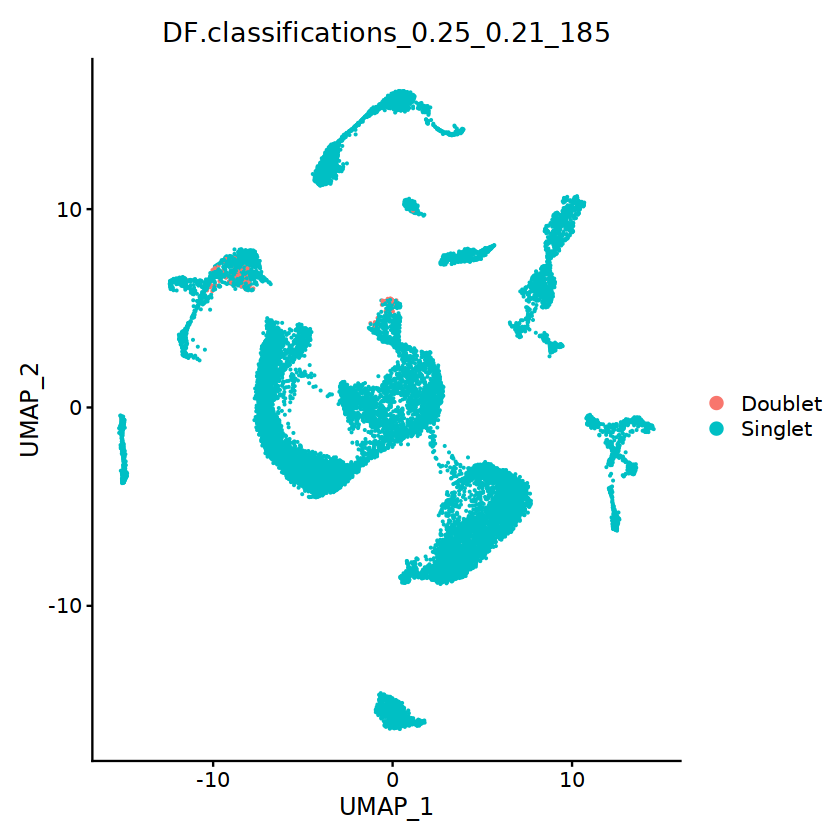

In [31]:
DimPlot(scRNA, reduction = "umap", group.by = "DF.classifications_0.25_0.21_185")

In [32]:
immune.combined = subset(scRNA, subset = DF.classifications_0.25_0.21_185  != 'Doublet')


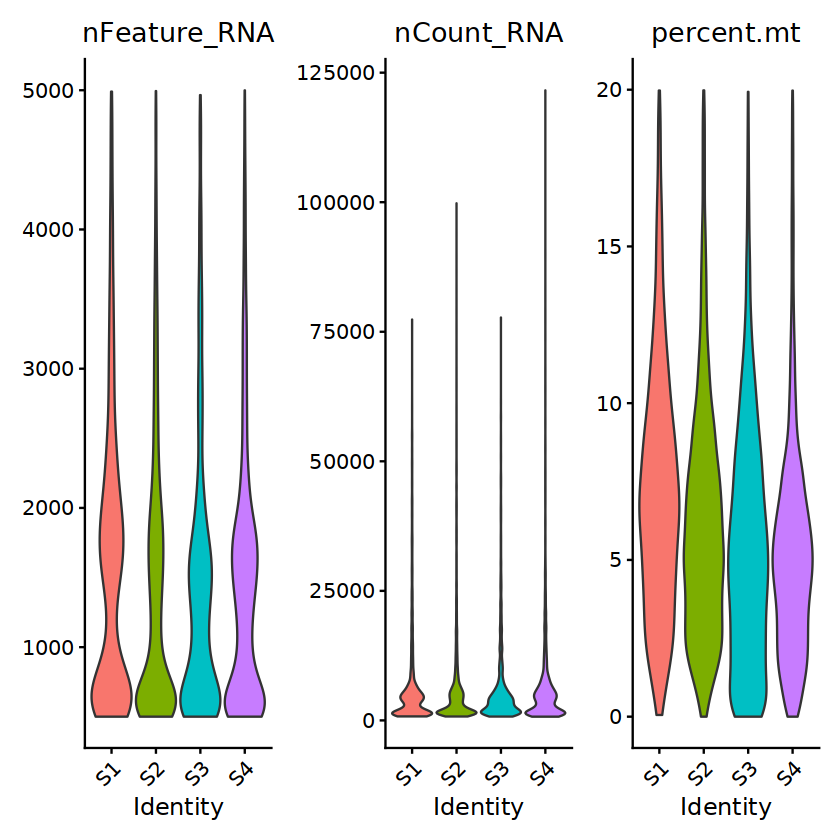

In [33]:
immune.combined <-   subset(immune.combined, subset = nFeature_RNA > 500 & nFeature_RNA < 5000 & percent.mt < 20)
VlnPlot(immune.combined, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3,pt.size = 0,group.by="orig.ident")


In [35]:
table(immune.combined$orig.ident)


  S1   S2   S3   S4 
3733 6672 2500 4847 

In [ ]:
# ifnb.list <- SplitObject(immune.combined, split.by = "orig.ident")

# testAB.anchors <- FindIntegrationAnchors(object.list = ifnb.list, dims = 1:20)
# testAB.integrated <- IntegrateData(anchorset = testAB.anchors, dims = 1:20)

# DefaultAssay(testAB.integrated) <- "integrated"
# # Run the standard workflow for visualization and clustering
# testAB.integrated <- ScaleData(testAB.integrated, features = rownames(testAB.integrated))
# testAB.integrated <- RunPCA(testAB.integrated, npcs = 50, verbose = FALSE)
# testAB.integrated <- FindNeighbors(testAB.integrated, dims = 1:30)
# testAB.integrated <- FindClusters(testAB.integrated, resolution = 0.5)
# testAB.integrated <- RunUMAP(testAB.integrated, dims = 1:30)
# testAB.integrated <- RunTSNE(testAB.integrated, dims = 1:30)

# immune.combined = testAB.integrated

In [36]:
options(repr.plot.width = 18,repr.plot.height = 9
       )

In [ ]:
#DimPlot(scRNA, reduction = "umap", split.by = "orig.ident",ncol = 4)

In [37]:
library(harmony)

Loading required package: Rcpp

Warning message:
"package 'Rcpp' was built under R version 4.2.3"


In [38]:
DefaultAssay(immune.combined) = 'RNA'

In [39]:
sceList <- SplitObject(immune.combined, split.by = "orig.ident")

In [40]:
single.ob=merge(sceList[[1]],sceList[2:length(sceList)])

In [41]:
DefaultAssay(single.ob) = 'RNA'

In [42]:
scRNA_harmony = single.ob

In [43]:
scRNA_harmony <- NormalizeData(scRNA_harmony) %>% FindVariableFeatures() %>% ScaleData() %>% RunPCA(verbose=FALSE)
##整合
system.time({scRNA_harmony <- RunHarmony(scRNA_harmony, group.by.vars = "orig.ident")})

Centering and scaling data matrix

Transposing data matrix

Initializing state using k-means centroids initialization

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony 4/10

Harmony converged after 4 iterations

Warning message:
"Invalid name supplied, making object name syntactically valid. New object name is Seurat..ProjectDim.RNA.harmony; see ?make.names for more details on syntax validity"


   user  system elapsed 
 12.217   5.538   9.549 

In [44]:
scRNA_harmony <- RunUMAP(scRNA_harmony, reduction = "harmony", dims = 1:20)

08:05:27 UMAP embedding parameters a = 0.9922 b = 1.112

08:05:27 Read 17752 rows and found 20 numeric columns

08:05:27 Using Annoy for neighbor search, n_neighbors = 30

08:05:27 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

08:05:29 Writing NN index file to temp file /tmp/RtmpibhLQ0/file3478a67a016d4

08:05:29 Searching Annoy index using 1 thread, search_k = 3000

08:05:34 Annoy recall = 100%

08:05:34 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

08:05:35 Initializing from normalized Laplacian + noise (using irlba)

08:05:41 Commencing optimization for 200 epochs, with 786598 positive edges

08:06:00 Optimization finished



In [45]:
scRNA_harmony <- FindNeighbors(scRNA_harmony, reduction = "harmony", dims = 1:20) %>% FindClusters(resolution =  0.3)
##作图
#group_by_cluster

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 17752
Number of edges: 689416

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9580
Number of communities: 18
Elapsed time: 4 seconds


In [46]:
options(repr.plot.width = 12,repr.plot.height = 8)

In [47]:
table(scRNA_harmony$orig.ident)


  S1   S2   S3   S4 
3733 6672 2500 4847 

In [48]:
scRNA_harmony$group = ifelse(scRNA_harmony$orig.ident %in% c('GSE196678','S1','S2','S3','S4'),'control','OS')

In [49]:
options(repr.plot.width = 8,repr.plot.height = 6)

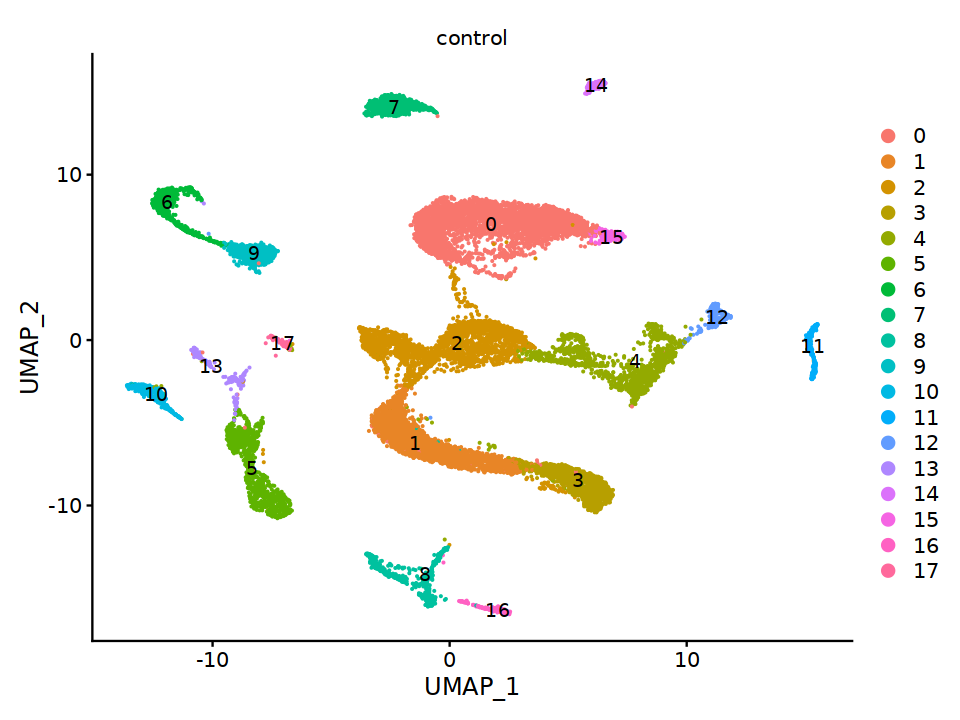

In [50]:
DimPlot(scRNA_harmony, reduction = "umap", split.by = "group",ncol = 2,label = T)

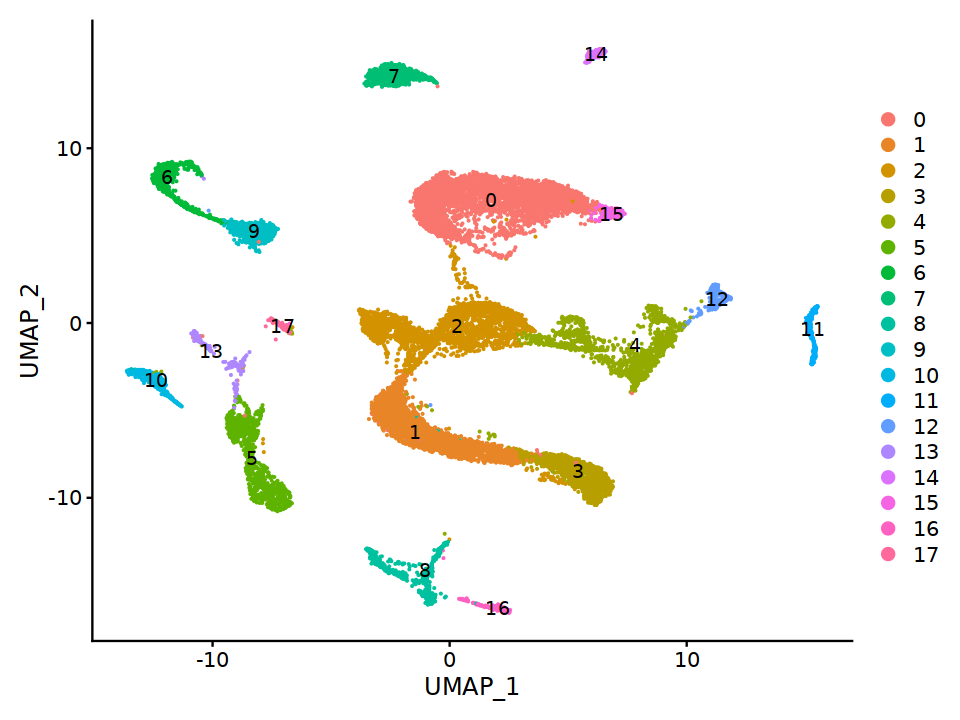

In [51]:
DimPlot(scRNA_harmony, reduction = "umap", label=T) 

In [52]:
FeaturePlot(scRNA_harmony,features = c('I'))

Warning message in FetchData.Seurat(object = object, vars = c(dims, "ident", features), :
"The following requested variables were not found: I"


ERROR: Error: None of the requested features were found: I in slot data


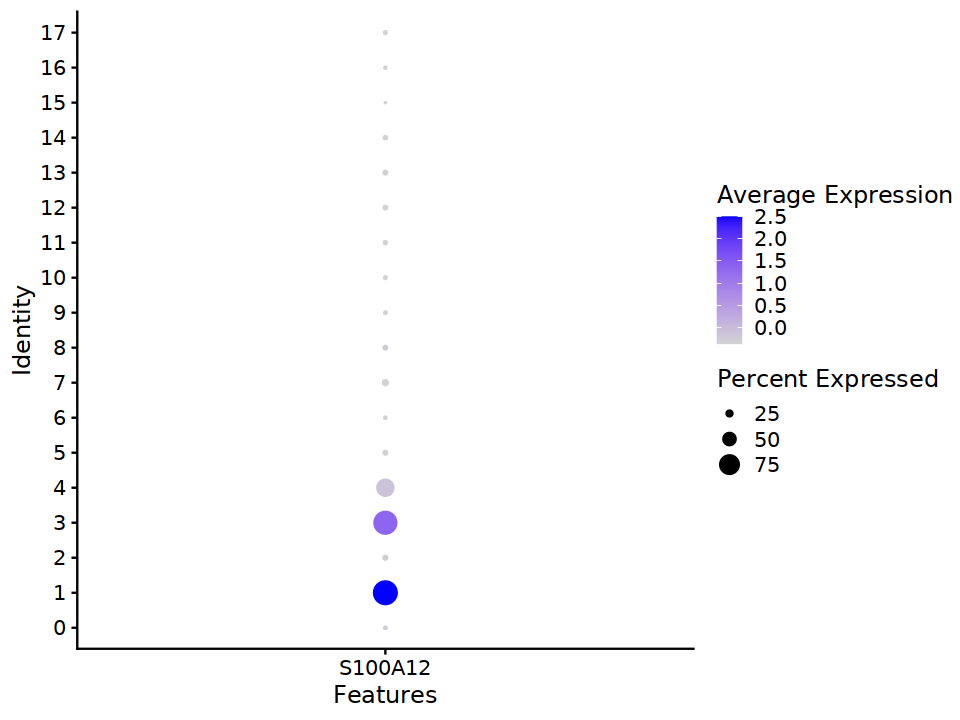

In [67]:
DotPlot(scRNA_harmony,features = c('S100A12'))

In [54]:
Idents(scRNA_harmony) = 'seurat_clusters'

In [55]:
DefaultAssay(scRNA_harmony) = 'RNA'

In [56]:
Idents(scRNA_harmony) = 'seurat_clusters'
DefaultAssay(scRNA_harmony) = 'RNA'
sce.markers <- FindAllMarkers(object = scRNA_harmony, only.pos = TRUE, 
                              min.pct = 0.25, 
                              thresh.use = 0.25)
 

library(dplyr) 
# 不同seurat版本的 avg_logFC 不一样 
top5 <- sce.markers %>% group_by(cluster) %>% top_n(5, avg_log2FC)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12

Calculating cluster 13

Calculating cluster 14

Calculating cluster 15

Calculating cluster 16

Calculating cluster 17



In [73]:
sce.markers %>%  dplyr::filter(cluster == 3)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
CXCL8,0,4.658610,0.992,0.403,0,3,CXCL8
NAMPT,0,4.278312,1.000,0.446,0,3,NAMPT
G0S2,0,4.207817,0.992,0.277,0,3,G0S2
FCGR3B,0,3.922028,0.819,0.048,0,3,FCGR3B
PTGS21,0,3.679788,0.874,0.183,0,3,PTGS2
CMTM2,0,3.586649,0.705,0.034,0,3,CMTM2
BCL2A11,0,3.361078,0.939,0.258,0,3,BCL2A1
IFITM21,0,3.349916,0.962,0.553,0,3,IFITM2
RGS2,0,3.261282,0.925,0.354,0,3,RGS2


In [ ]:
10 13 14 15 b 
7 ENDO
0 6 T
2 4 17  MYE
1 3 20  MESE...

5 12 neu

In [62]:
Idents(scRNA_harmony) = 'seurat_clusters'
DefaultAssay(scRNA_harmony) = 'RNA'
sce.markers <- FindAllMarkers(object = scRNA_harmony, only.pos = TRUE, 
                              min.pct = 0.25, 
                              thresh.use = 0.25)
 

library(dplyr) 
# 不同seurat版本的 avg_logFC 不一样 
top5 <- sce.markers %>% group_by(cluster) %>% top_n(5, avg_log2FC)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12

Calculating cluster 13

Calculating cluster 14

Calculating cluster 15

Calculating cluster 16

Calculating cluster 17

Calculating cluster 18

Calculating cluster 19

Calculating cluster 20



In [64]:
write.csv(sce.markers,file = 'sce.markers.csv')

In [63]:
table(scRNA_harmony$orig.ident,scRNA_harmony$seurat_clusters)

              
                   0     1     2     3     4     5     6     7     8     9
  GSE196678    15340   232   623   353   548    26  4544   333   220  2833
  S1             461    16   121    27   188  1019    29    26     6     1
  S2            1132   120   133    96   394  2203    81    97    62    24
  S3             593    30    31    21   109   448    51    27     8    16
  S4            1497    34    10    60   210  1101   144    41    74    16
  WH2109002886  1622  1846  2493  1230   739    31   160   105   215    33
  WH2109013167   610  1975   708   527   250     1    43   288   212    24
  WH2112008442   451  2405  1588  2792   458    13    78   397  1329    16
  WH2201006389   632  2204  1073  1164   270     8    55  2559   744   146
  WH2203005877   581   185  1472   316  2583   699   126    79   567     0
              
                  10    11    12    13    14    15    16    17    18    19
  GSE196678     1032   102    21  1650   233   413    19    12     2  

In [65]:
immune.combined = scRNA_harmony

In [66]:
saveRDS(immune.combined,file = 'before_rename.rds')

In [67]:
ggsave('figure3.pdf',height =  4,width = 5)

In [68]:
ggsave('figure4.pdf',height =  8,width = 12)

In [174]:
scRNA = immune.combined

In [175]:
library(Seurat) ##
library(SingleR)
library(ggplot2)
library(reshape2)
mouseImmu  = get(load('/import/DB/SingleR_ref/ref_Human_all.RData'))

In [176]:
pbmc_for_SingleR <- GetAssayData(scRNA, slot="data") ##获取标准化矩阵
clusters=scRNA@meta.data$seurat_clusters

In [177]:
pred.mouseImmu <- SingleR(test = pbmc_for_SingleR, ref = mouseImmu, labels = mouseImmu$label.main,
 method = "cluster", clusters = clusters, 
 assay.type.test = "logcounts", assay.type.ref = "logcounts")
celltype = data.frame(ClusterID=rownames(pred.mouseImmu), celltype=pred.mouseImmu$labels, stringsAsFactors = FALSE)

Warning message:
"useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE."
Warning message:
"useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE."
Warning message:
"useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE."
Warning message:
"useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE."
Warning message:
"useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE."
Warning message:
"useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE."
Warning message:
"useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE."
Warning message:
"useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE."
Warning message:
"useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE."
Warning message:
"useNames =

In [178]:
celltype$celltype = c('T/NK','Mesenchyme/osteoclast',
                      'Myeloid','Mesenchyme/osteoclast','Myeloid',
                      'Neutrophils','T/NK',
                      'Endo','Mesenchyme/osteoclast',
                      'Mesenchyme/osteoclast','B',
                      'Mesenchyme/osteoclast','Neutrophils',
                      'B','B',
                      'B','Mast',
                      'Myeloid','Mesenchyme/osteoclast',
                      'Mesenchyme/osteoclast','Mesenchyme/osteoclast')

In [179]:
scRNA@meta.data$celltype = "NA"
# 赋值
for(i in 1:nrow(celltype)){
  scRNA@meta.data[which(scRNA@meta.data$seurat_clusters == celltype$ClusterID[i]),'celltype'] <- celltype$celltype[i]}

In [180]:
table(scRNA$celltype)


                    B                  Endo                  Mast 
                 6364                  3952                   541 
Mesenchyme/osteoclast               Myeloid           Neutrophils 
                25773                 14538                  8099 
                 T/NK 
                28230 

In [181]:
library(Seurat)

In [182]:
options(repr.plot.width = 8,repr.plot.height = 5)

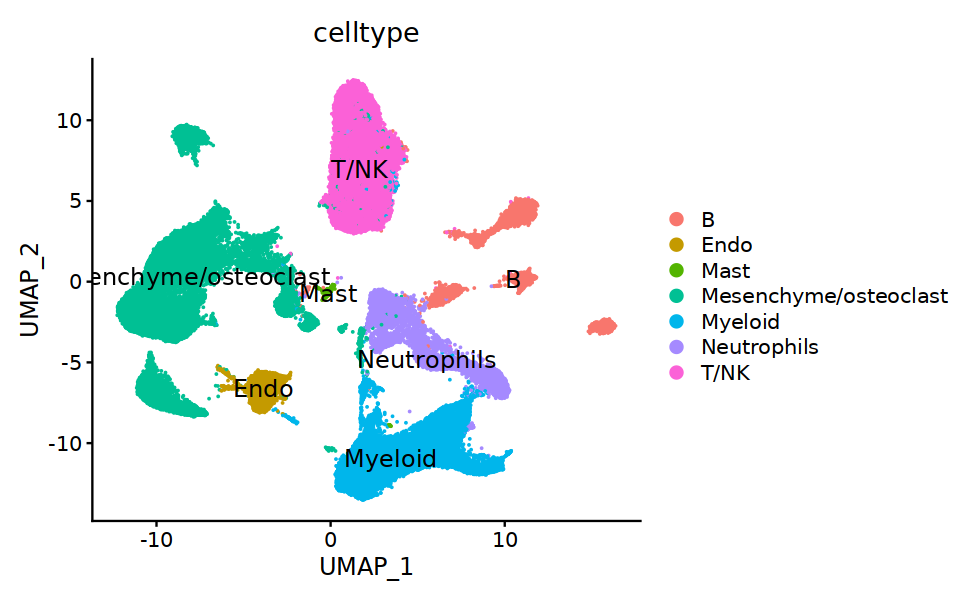

In [183]:
DimPlot(scRNA, group.by="celltype", label=T, label.size=5, reduction='umap')

In [184]:
data = scRNA@meta.data 

In [185]:
data$barcode = rownames(data)

In [186]:
part1 = data %>% dplyr::filter(orig.ident == 'GSE196678')

In [187]:
part2 = data %>% dplyr::filter(orig.ident != 'GSE196678')

In [188]:
library("stringr")  
anno2 = part1 %>%  mutate(
    sample = case_when(
        str_sub(barcode, - 4, - 1) == '-1_1' ~'C1',
        str_sub(barcode, - 4, - 1) == '-2_1' ~'C2',
        str_sub(barcode, - 4, - 1) == '-3_1' ~'C3',
        str_sub(barcode, - 4, - 1) == '-4_1' ~'C4',
        .default = orig.ident

    )
  )

In [189]:
part2$sample = part2$orig.ident

In [190]:
anno3  = rbind(part2,anno2)

In [191]:
scRNA@meta.data = anno3

In [192]:
table(scRNA$sample)


          C1           C2           C3           C4           S1           S2 
        6409         6746         7611         7774         3644         6534 
          S3           S4 WH2109002886 WH2109013167 WH2112008442 WH2201006389 
        2465         4752        10007         4997        10050         9475 
WH2203005877 
        7033 

In [193]:
saveRDS(scRNA,file = 'scRNA.rds')

In [134]:
Idents(scRNA) = 'celltype'

sce.markers <- FindAllMarkers(object = scRNA, only.pos = TRUE, 
                              min.pct = 0.25, 
                              thresh.use = 0.25)
 



Calculating cluster T/NK

Calculating cluster B

Calculating cluster Mesenchyme/osteoclast

Calculating cluster Neutrophils

Calculating cluster Myeloid

Calculating cluster Endo

Calculating cluster Mast



In [140]:
library(dplyr) 
# 不同seurat版本的 avg_logFC 不一样 
top5 <- sce.markers %>% group_by(cluster) %>% top_n(5, avg_log2FC)

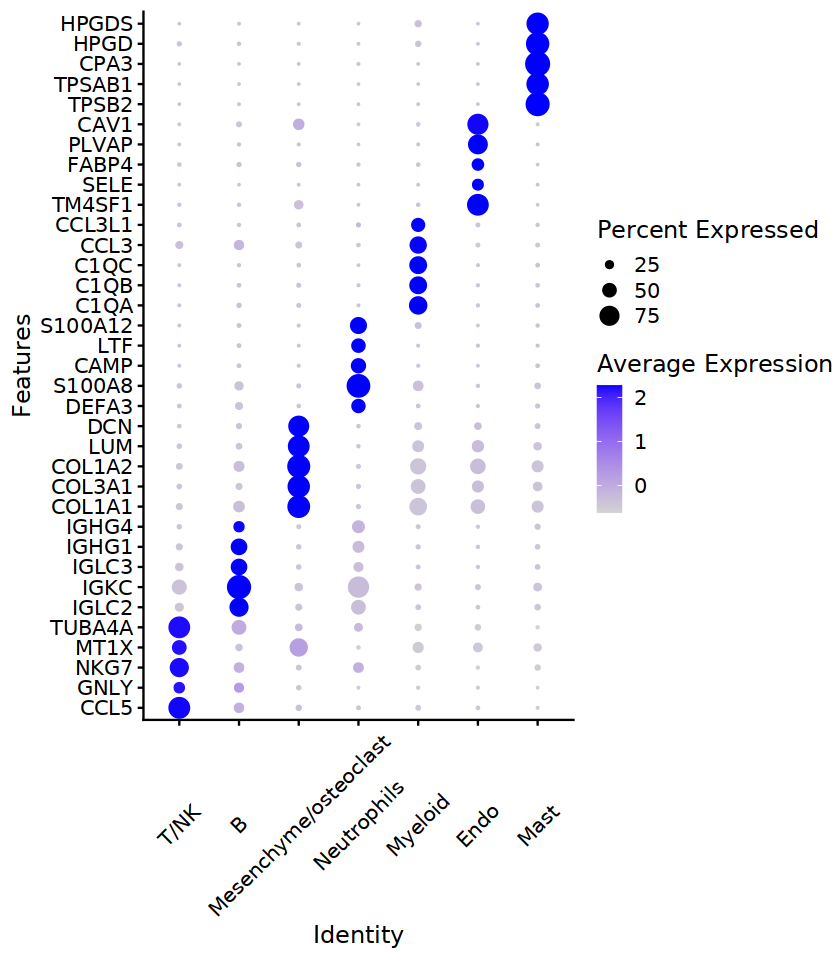

In [142]:
options(repr.plot.height = 8,repr.plot.width = 7)

 DotPlot(scRNA, features = unique(top5$gene) ,
 assay='RNA' ) + coord_flip()+ theme(axis.text.x = element_text(angle = 45, 
 vjust = 0.5, hjust=0.5))

In [219]:
scedata = scRNA

In [220]:
scedata$orig.ident = scedata$sample

In [229]:
Idents(scedata) = 'celltype'

In [230]:
table(scedata$orig.ident)#查看各组细胞数
prop.table(table(Idents(scedata)))
table(Idents(scedata), scedata$orig.ident)#各组不同细胞群细胞数


          C1           C2           C3           C4           S1           S2 
        6409         6746         7611         7774         3644         6534 
          S3           S4 WH2109002886 WH2109013167 WH2112008442 WH2201006389 
        2465         4752        10007         4997        10050         9475 
WH2203005877 
        7033 


                    B Mesenchyme/osteoclast           Neutrophils 
          0.072733922           0.294558671           0.092563174 
              Myeloid                  T/NK                  Endo 
          0.166154268           0.322639633           0.045167263 
                 Mast 
          0.006183069 

                       
                          C1   C2   C3   C4   S1   S2   S3   S4 WH2109002886
  B                       34   29   15  267  640 1421  618  257          348
  Mesenchyme/osteoclast 4126 4373 3765 1542  179  280  100   73         2653
  Neutrophils              7   12    7  701    7   21    4    9            6
  Myeloid               1368 1341 1158 4171  336  477   99   49          195
  T/NK                   498  385  557  758 2450 4280 1628 4299         6635
  Endo                   289  527 2031  304   30   45   12   64          168
  Mast                    87   79   78   31    2   10    4    1            2
                       
                        WH2109013167 WH2112008442 WH2201006389 WH2203005877
  B                             1027         1109          472          127
  Mesenchyme/osteoclast          920         1276         2993         3493
  Neutrophils                   1532         4486         1288           19
  Myeloid                       

In [231]:
Cellratio <- prop.table(table(Idents(scedata), scedata$orig.ident), margin = 2)#计算各组样本不同细胞群比例
Cellratio <- data.frame(Cellratio)

In [232]:
library(reshape2)
cellper <- dcast(Cellratio,Var2~Var1, value.var = "Freq")#长数据转为宽数据
rownames(cellper) <- cellper[,1]
cellper <- cellper[,-1]

In [233]:
sample <- rownames(cellper)

In [234]:
sample

[1] "C1"           "C2"           "C3"           "C4"           "S1"          
 [6] "S2"           "S3"           "S4"           "WH2109002886" "WH2109013167"
[11] "WH2112008442" "WH2201006389" "WH2203005877"

In [235]:
group <- c(rep('Con',8),rep('OS',5))


samples <- data.frame(sample, group)#创建数据框

rownames(samples)=samples$sample
cellper$sample <- samples[rownames(cellper),'sample']#R添加列
cellper$group <- samples[rownames(cellper),'group']#R添加列

###作图展示
pplist = list()
sce_groups = unique(scRNA$celltype)


In [244]:
library(ggplot2)
library(dplyr)
library(ggpubr)
library(cowplot)
for(group_ in sce_groups){
  cellper_  = cellper %>% select(one_of(c('sample','group',group_)))#选择一组数据
  colnames(cellper_) = c('sample','group','percent')#对选择数据列命名
  cellper_$percent = as.numeric(cellper_$percent)#数值型数据
  cellper_ <- cellper_ %>% group_by(group) %>% mutate(upper =  quantile(percent, 0.75), 
                                                      lower = quantile(percent, 0.25),
                                                      mean = mean(percent),
                                                      median = median(percent))#上下分位数
# print(group_)
print(cellper_$median)
      pp1 = ggplot(cellper_,aes(x=group,y=percent)) + #ggplot作图
    geom_jitter(shape = 21,aes(fill=group),width = 0.25) + 
    stat_summary(fun=mean, geom="point", color="grey60") +
    theme_cowplot() +
    theme(axis.text = element_text(size = 10),axis.title = element_text(size = 10),legend.text = element_text(size = 10),
          legend.title = element_text(size = 10),plot.title = element_text(size = 10,face = 'plain'),legend.position = 'none') + 
    labs(title = group_,y='Percentage') +
    geom_errorbar(aes(ymin = lower, ymax = upper),col = "grey60",width =  1)
  
  ###组间t检验分析
  labely = max(cellper_$percent)
  compare_means(percent ~ group,  data = cellper_)
  my_comparisons <- list( c("Con", "OS") )
  pp1 = pp1 + stat_compare_means(comparisons = my_comparisons,size = 3,method = "t.test")
  pplist[[group_]] = pp1
}
  

 [1] 0.04421387 0.04421387 0.04421387 0.04421387 0.04421387 0.04421387
 [7] 0.04421387 0.04421387 0.04981530 0.04981530 0.04981530 0.04981530
[13] 0.04981530
 [1] 0.1237377 0.1237377 0.1237377 0.1237377 0.1237377 0.1237377 0.1237377
 [8] 0.1237377 0.2651144 0.2651144 0.2651144 0.2651144 0.2651144
 [1] 0.001836386 0.001836386 0.001836386 0.001836386 0.001836386 0.001836386
 [7] 0.001836386 0.001836386 0.135936675 0.135936675 0.135936675 0.135936675
[13] 0.135936675
 [1] 0.12217729 0.12217729 0.12217729 0.12217729 0.12217729 0.12217729
 [7] 0.12217729 0.12217729 0.07283582 0.07283582 0.07283582 0.07283582
[13] 0.07283582
 [1] 0.3762699 0.3762699 0.3762699 0.3762699 0.3762699 0.3762699 0.3762699
 [8] 0.3762699 0.2225335 0.2225335 0.2225335 0.2225335 0.2225335
 [1] 0.02628636 0.02628636 0.02628636 0.02628636 0.02628636 0.02628636
 [7] 0.02628636 0.02628636 0.01323383 0.01323383 0.01323383 0.01323383
[13] 0.01323383
 [1] 0.002805185 0.002805185 0.002805185 0.002805185 0.002805185 0.00280518

In [245]:
options(repr.plot.height = 8,repr.plot.width = 9)

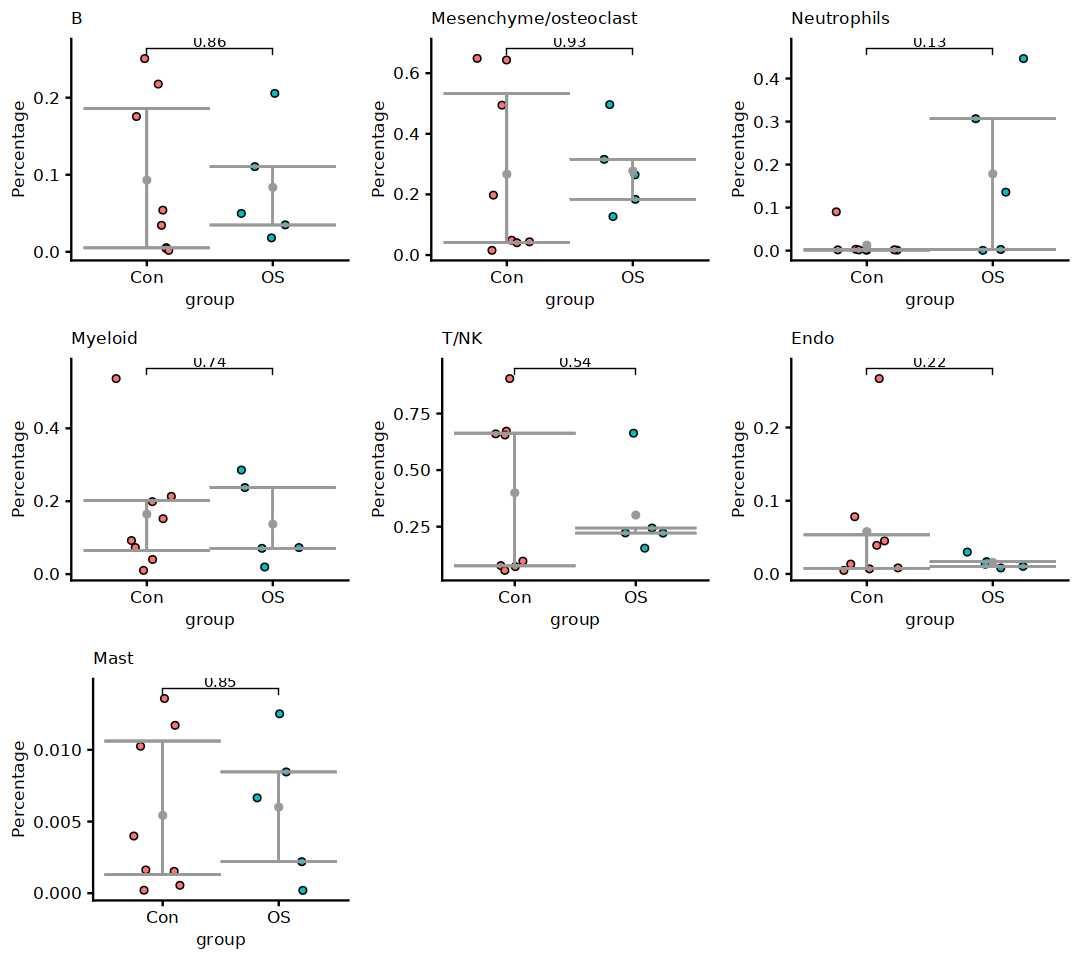

In [246]:
 library(cowplot)
plot_grid(pplist[[1]],
          pplist[[2]],
          pplist[[3]],
          pplist[[4]],
          pplist[[5]],
          pplist[[6]],
          pplist[[7]])


   GSE196678           S1           S2           S3           S4 WH2109002886 
       28540         3644         6534         2465         4752        10007 
WH2109013167 WH2112008442 WH2201006389 WH2203005877 
        4997        10050         9475         7033 


                    B Mesenchyme/osteoclast           Neutrophils 
          0.072733922           0.294558671           0.092563174 
              Myeloid                  T/NK                  Endo 
          0.166154268           0.322639633           0.045167263 
                 Mast 
          0.006183069 

                       
                           OS control
  B                       644    5720
  Mesenchyme/osteoclast 19833    5940
  Neutrophils             772    7327
  Myeloid               12136    2402
  T/NK                   4358   23872
  Endo                   3428     524
  Mast                    391     150

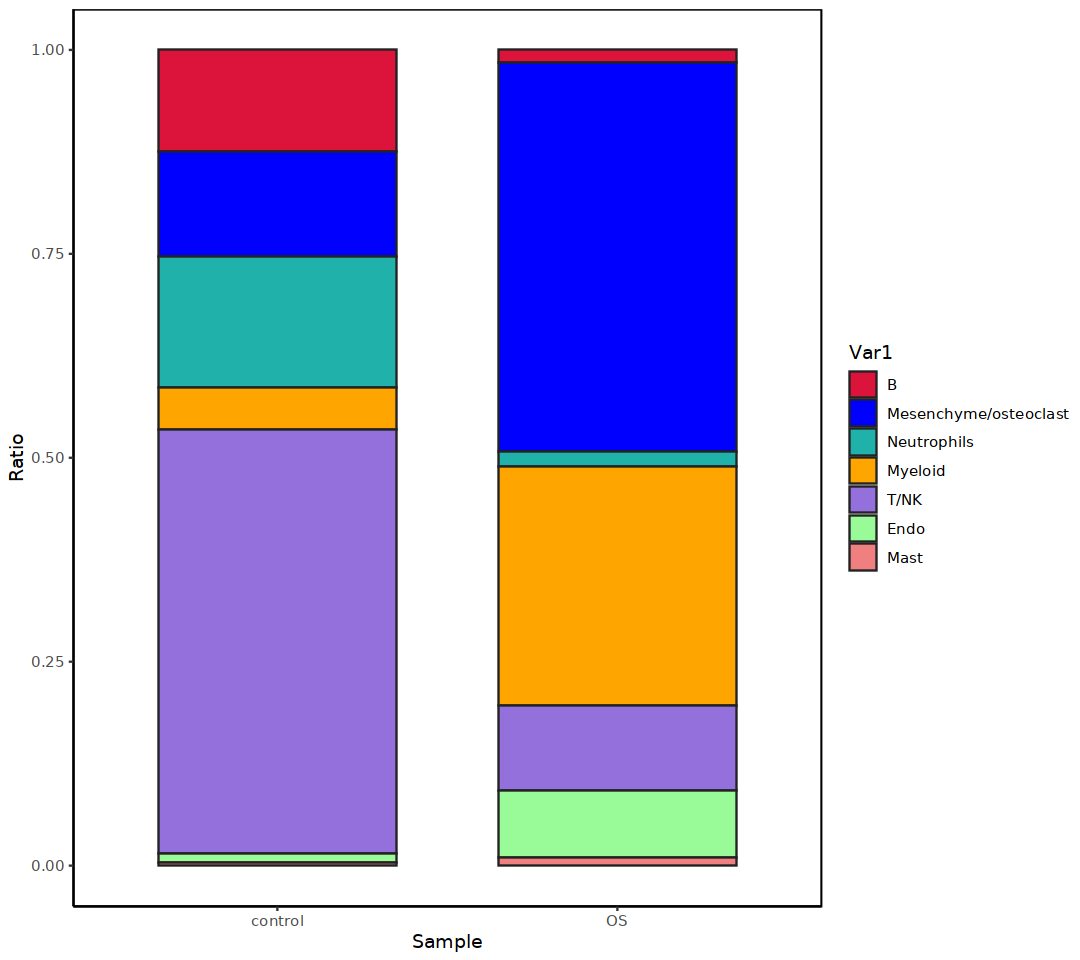

In [265]:
Idents(scRNA) ='celltype'

scedata = scRNA
table(scedata$orig.ident)#查看各组细胞数
prop.table(table(Idents(scedata)))
table(Idents(scedata), scedata$group)#各组不同细胞群细胞数
Cellratio <- prop.table(table(Idents(scedata), scedata$group), margin = 2)#计算各组样本不同细胞群比例
Cellratio <- as.data.frame(Cellratio)

Cellratio$Var2 = factor(Cellratio$Var2,levels = c('control','OS'))

allcolour=c("#DC143C","#0000FF","#20B2AA","#FFA500","#9370DB","#98FB98","#F08080","#1E90FF","#7CFC00","#FFFF00",
            "#808000","#FF00FF","#FA8072","#7B68EE","#9400D3","#800080","#A0522D","#D2B48C","#D2691E","#87CEEB","#40E0D0","#5F9EA0",
            "#FF1493","#0000CD","#008B8B","#FFE4B5","#8A2BE2","#228B22","#E9967A","#4682B4","#32CD32","#F0E68C","#FFFFE0","#EE82EE",
            "#FF6347","#6A5ACD","#9932CC","#8B008B","#8B4513","#DEB887")
library(ggplot2)
ggplot(Cellratio) + 
  geom_bar(aes(x =Var2, y= Freq, fill = Var1),stat = "identity",width = 0.7,size = 0.5,colour = '#222222')+ 
  theme_classic() +
  labs(x='Sample',y = 'Ratio')+
  scale_fill_manual(values = allcolour)+
  theme(panel.border = element_rect(fill=NA,color="black", size=0.5, linetype="solid"))

library(Seurat)
library(ggplot2)
library(dplyr)
library(ggalluvial)

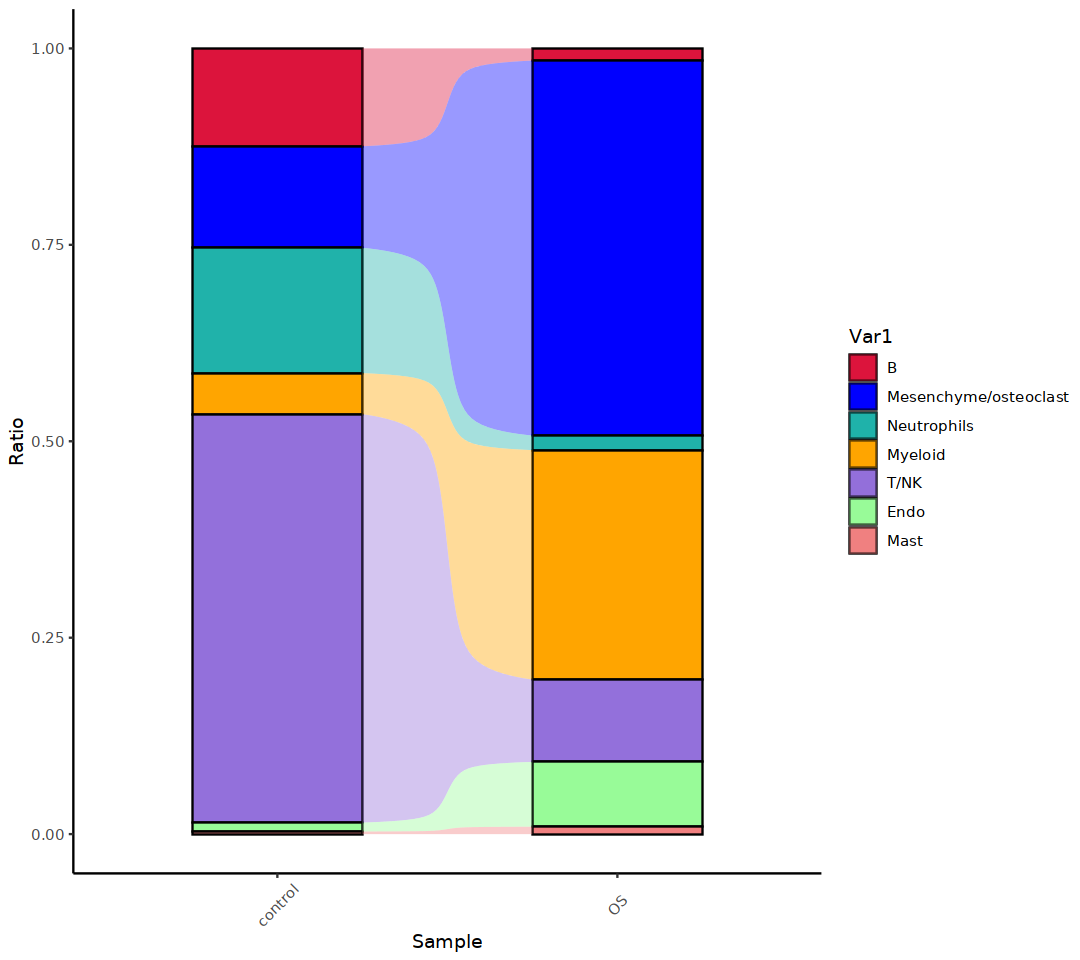

In [266]:
ggplot(Cellratio, aes(x =Var2, y= Freq, fill = Var1,
                  stratum=Var1, alluvium=Var1)) +
  geom_col(width = 0.5, color='black')+
  geom_flow(width=0.5,alpha=0.4, knot.pos=0.5)+ # 参数knot.pos设置为0.5使连接为曲线面积，就像常见的桑基图
  theme_classic() +
  labs(x='Sample',y = 'Ratio')+
  scale_fill_manual(values = allcolour) + theme(axis.text.x = element_text(angle = 45, 
 vjust = 0.5, hjust=0.5))

In [288]:
library(miloR)
library(SingleCellExperiment)
library(scater)
library(scran)
library(dplyr)
library(patchwork)

Warning message in .check_reddim_names(x, value, withDimnames):
"non-NULL 'rownames(value)' should be the same as 'colnames(x)' for
'reducedDim<-'. This will be an error in the next release of
Bioconductor."
Warning message in .check_reddim_names(x, value, withDimnames):
"non-NULL 'rownames(value)' should be the same as 'colnames(x)' for
'reducedDim<-'. This will be an error in the next release of
Bioconductor."
Warning message in .check_reddim_names(x, value, withDimnames):
"non-NULL 'rownames(value)' should be the same as 'colnames(x)' for
'reducedDim<-'. This will be an error in the next release of
Bioconductor."


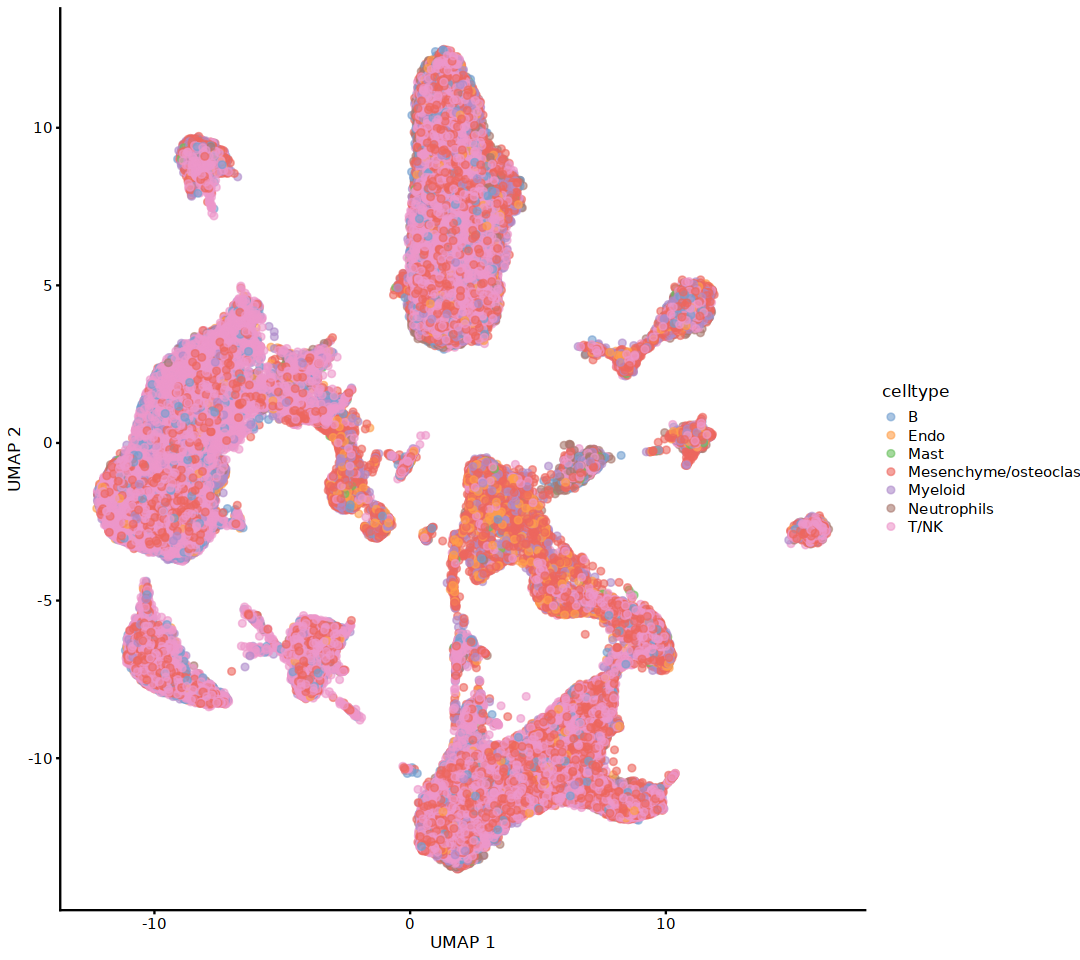

In [289]:
sce <- as.SingleCellExperiment(scedata)
 
#Visualize the data
plotReducedDim(sce, colour_by="celltype", dimred = "UMAP") 

Constructing kNN graph with k:20

Checking valid object

Running refined sampling with reduced_dim

Checking meta.data validity

Counting cells in neighbourhoods

  [[ suppressing 13 column names 'S1', 'S2', 'S3' ... ]]



6 x 13 sparse Matrix of class "dgCMatrix"
                                 
1 . . . 45 24  .  . . . . .  .  .
2 . . .  .  .  .  . . . . 5 30  5
3 . . .  .  .  .  . . . . 1  . 41
4 . . .  . 89 22  . . . . .  .  .
5 . . .  .  .  4 32 . . . .  .  .
6 . . .  .  .  2 17 4 . . .  .  .

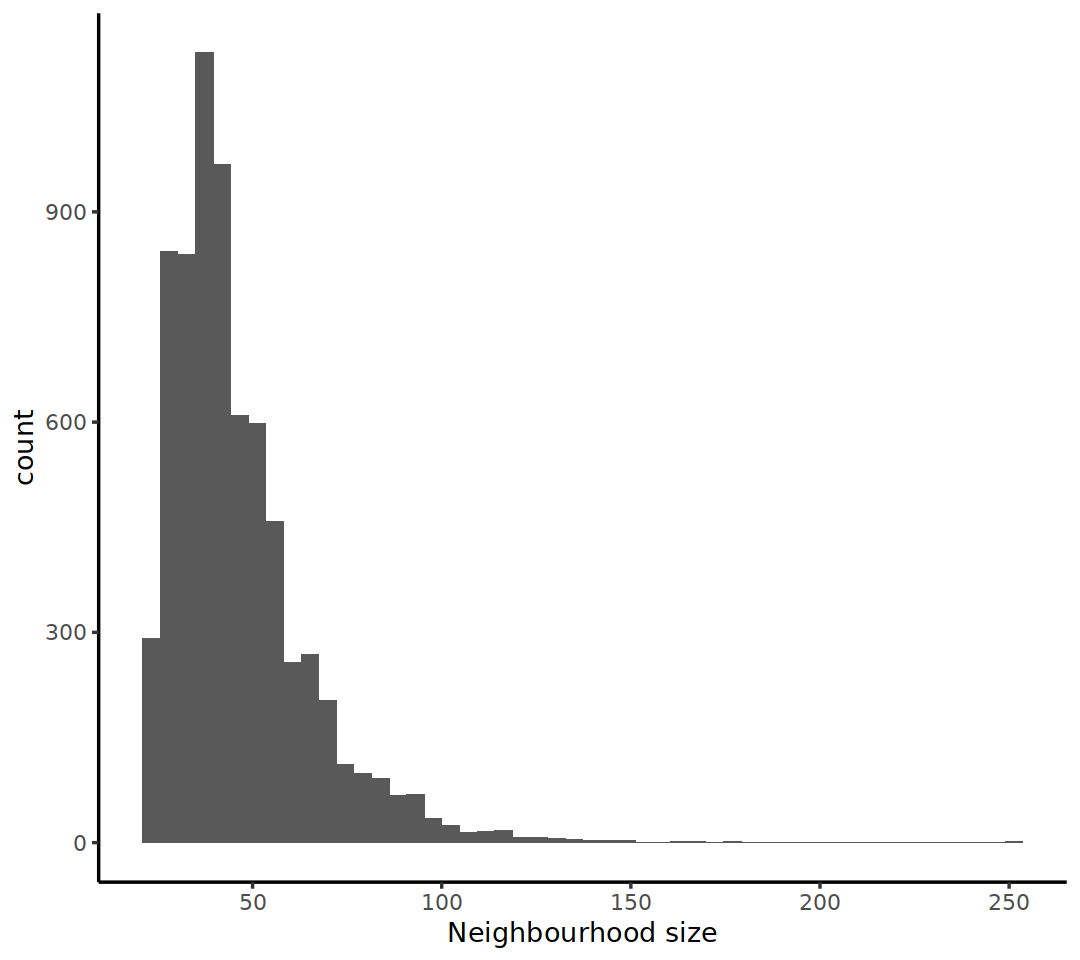

In [291]:
scmilo <- Milo(sce)
 
#Construct KNN graph
scmilo <- buildGraph(scmilo, k = 20, d = 20,reduced.dim = "PCA")
 
#Defining representative neighbourhoods on the KNN graph
set.seed(10)
scmilo <- makeNhoods(scmilo, prop = 0.1,
                     k = 20, d = 20, 
                     refined = TRUE, reduced_dims = "PCA")
plotNhoodSizeHist(scmilo)
 
#Counting cells in neighbourhoods
scmilo <- countCells(scmilo, 
                     meta.data = as.data.frame(colData(scmilo)), 
                     sample = "sample")
head(nhoodCounts(scmilo))

In [292]:
sc_design <- data.frame(colData(scmilo))[,c("sample", "group")]
 
sc_design <- distinct(sc_design)
rownames(sc_design) <- sc_design$sample

In [293]:
sc_design = sc_design[c(5:9,1:4,10:13),]

In [ ]:

#Computing neighbourhood connectivity
scmilo <- calcNhoodDistance(scmilo, d = 20, reduced.dim = "PCA")

In [ ]:
#Testing
results <- testNhoods(scmilo, design = ~ group, 
                      design.df = sc_design, reduced.dim="PCA")
head(results)
 
results %>%
  arrange(SpatialFDR) %>%
  head() 

In [ ]:
ggplot(results, aes(PValue)) + geom_histogram(bins=50)
ggplot(results, aes(logFC, -log10(SpatialFDR))) + 
  geom_point() +
  geom_hline(yintercept = 1) 

In [ ]:
scmilo <- buildNhoodGraph(scmilo)
 
## Plot single-cell UMAP
umap_pl <- plotReducedDim(scmilo, dimred = "UMAP", 
                          colour_by="celltype", text_by = "celltype", 
                          text_size = 3, point_size=0.5) +
  guides(fill="none")
 
## Plot neighbourhood graph
nh_graph_pl <- plotNhoodGraphDA(scmilo, results, layout="UMAP",alpha = 1) 
 
umap_pl + nh_graph_pl +
  plot_layout(guides="collect")

In [ ]:
results <- annotateNhoods(scmilo, results, coldata_col = "celltype")

In [ ]:
table(results$celltype)

In [ ]:
plotDAbeeswarm(results, group.by = "celltype",alpha = 1)